In [12]:
from hmrGC_dualEcho.dual_echo import DualEcho
import numpy as np
import matplotlib.pyplot as plt
from helper import *
GYRO = 42.57747892 # MHz/T

In [13]:
# Set colormap for different image types
cmap_img_type = {}
cmap_img_type['water'] = 'gray'
cmap_img_type['fat'] = 'gray'
cmap_img_type['fieldmap'] = 'magma'

In [14]:
## Signal model and fat model
def dual_echo_model(w, f, b0_Hz, fatmodel, fieldstrength_T, te_s):
    c = np.sum(fatmodel["relAmps"] * np.exp(1j * 2 * np.pi * GYRO * fieldstrength_T * fatmodel["freqs_ppm"] * te_s))
    return (w + f * c) * np.exp(1j * 2 * np.pi * b0_Hz * te_s)

fatmodel = {'freqs_ppm': np.array([-3.8 , -3.4 , -3.1 , -2.68, -2.46, -1.95, -0.5 ,  0.49,  0.59]),
            'relAmps': np.array([0.08991009, 0.58341658, 0.05994006, 0.08491508, 0.05994006, 0.01498501, 
                0.03996004, 0.00999001, 0.05694306]),
            'name': 'Ren marrow'}
fieldstrength_T = 3.0
centerFreq_MHz = GYRO * fieldstrength_T

## Phantom

In [15]:
b0 = np.linspace(-200, 200, 128)  # B0 inhomogeneity in Hz from -100 to 100 
_, b0_grid = np.meshgrid(np.zeros_like(b0), b0)

In [16]:
fieldmap = np.repeat(b0_grid[:,:,np.newaxis], 20, axis=2)
water, fat, mask = water_fat_shepp_logan()
fieldmap[mask] = 0

/home/jstelter/2echo-WaterFat-hmrGC/notebooks/helper.py:88: RuntimeWarning: invalid value encountered in divide
  fat_fraction = fat / (water+fat)


In [17]:
echoTimes_s = np.array([1.0, 2.1])*1e-3  # Echo times in seconds

In [18]:
# Forward simulate water and fat signals
signal_no_noise = np.zeros((water.shape[0], water.shape[1], water.shape[2], len(echoTimes_s)), dtype=complex)
for i in range(len(echoTimes_s)):
    signal_no_noise[:, :, :, i] = dual_echo_model(water, fat, fieldmap, fatmodel, fieldstrength_T, echoTimes_s[i])

In [19]:
def nrmse(x, y):
    return np.sqrt(np.sum((x - y)**2)) / (np.max(y)-np.min(y))

def mse(x, y):
    return np.mean((x - y)**2)

Dual-echo method: multi-res
1/6: Phasors... done! (0.02s)
2/6: Unwrapping... done! (0.03s)
3/6: Low-res... done! (0.07s)
4/6: Mid-res... 

/home/jstelter/2echo-WaterFat-hmrGC/hmrGC_dualEcho/dual_echo.py:209: RuntimeWarning: invalid value encountered in divide
  phasors_masked = phasors_masked / xp.abs(phasors_masked)


done! (0.25s)
5/6: High-res... done! (0.25s)
6/6: Images... done! (0.01s)


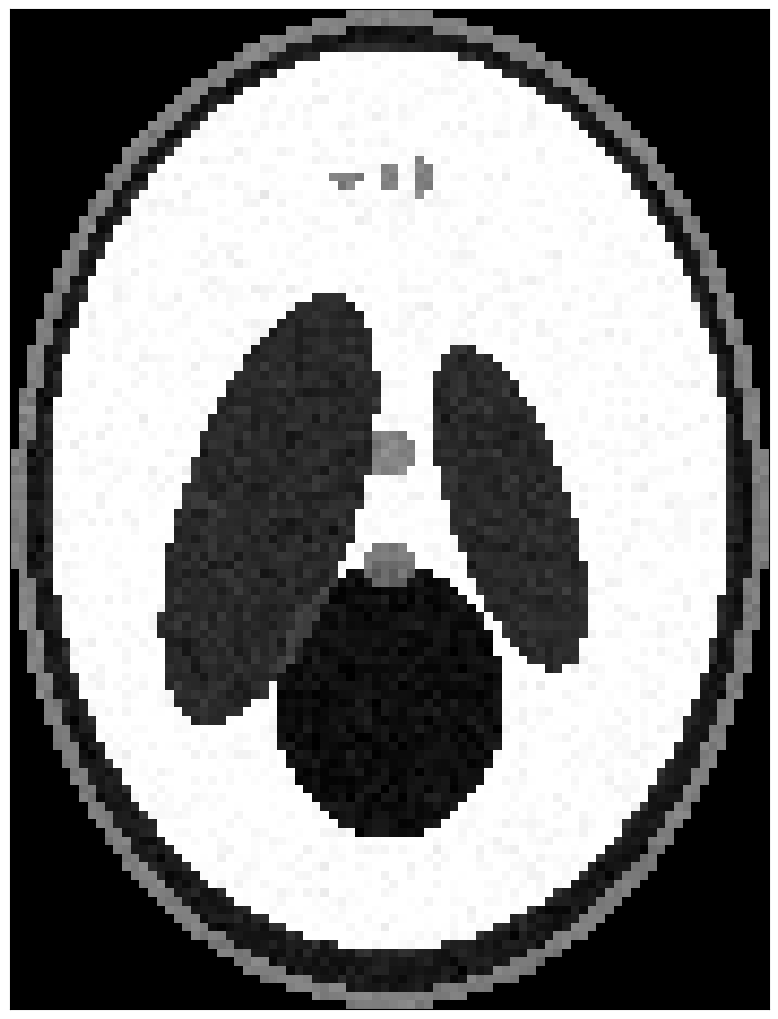

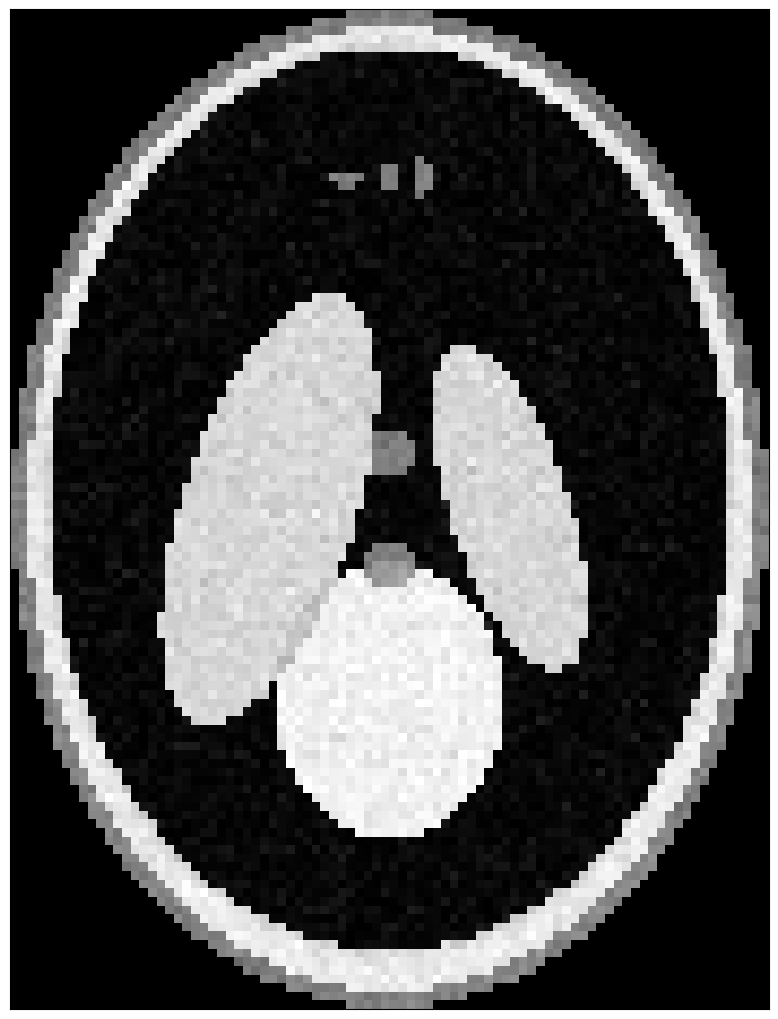

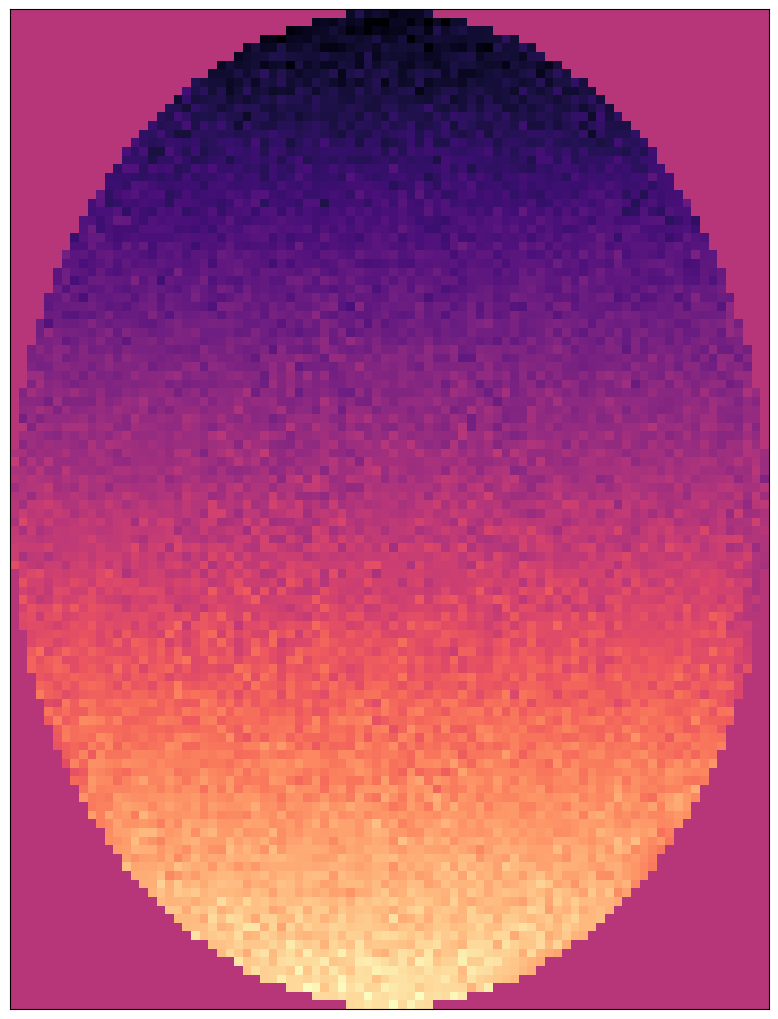

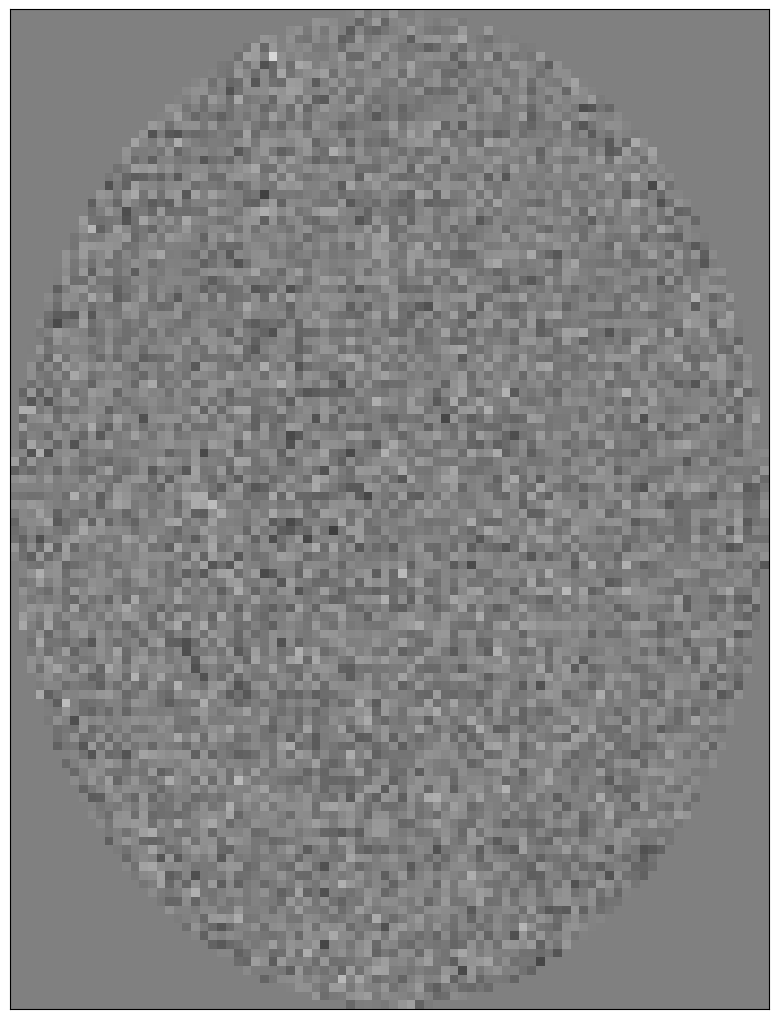

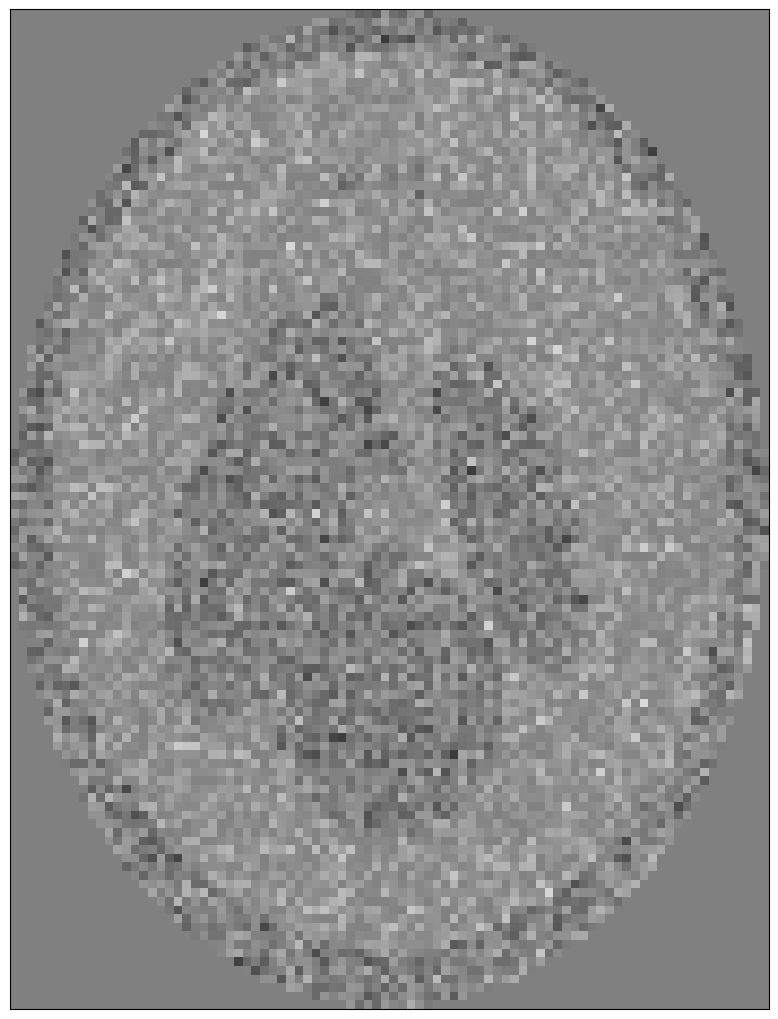

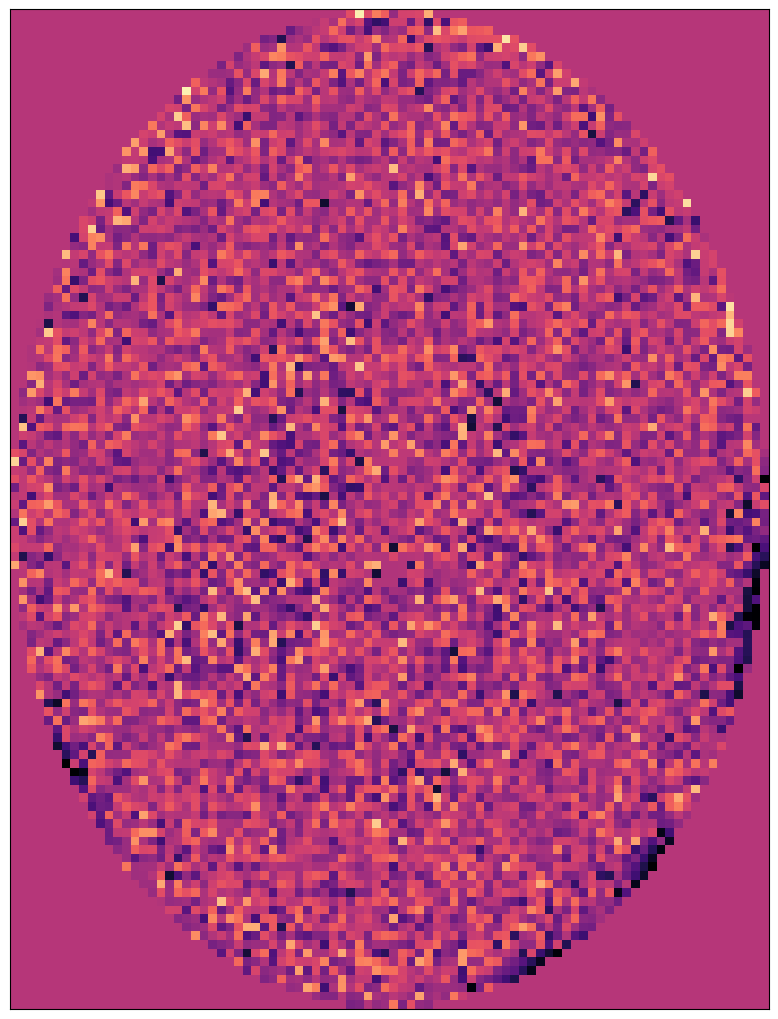

Dual-echo method: multi-res
1/6: Phasors... done! (0.02s)
2/6: Unwrapping... done! (0.03s)
3/6: Low-res... done! (0.07s)
4/6: Mid-res... 

/home/jstelter/2echo-WaterFat-hmrGC/hmrGC_dualEcho/dual_echo.py:209: RuntimeWarning: invalid value encountered in divide
  phasors_masked = phasors_masked / xp.abs(phasors_masked)


done! (0.26s)
5/6: High-res... done! (0.28s)
6/6: Images... done! (0.01s)


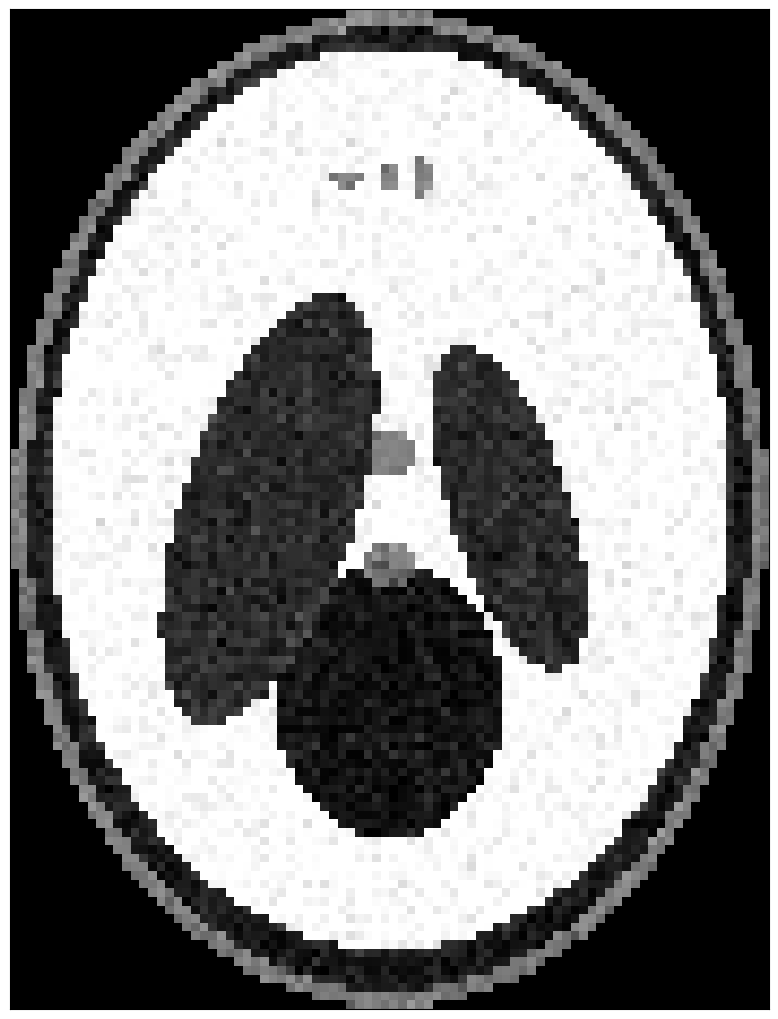

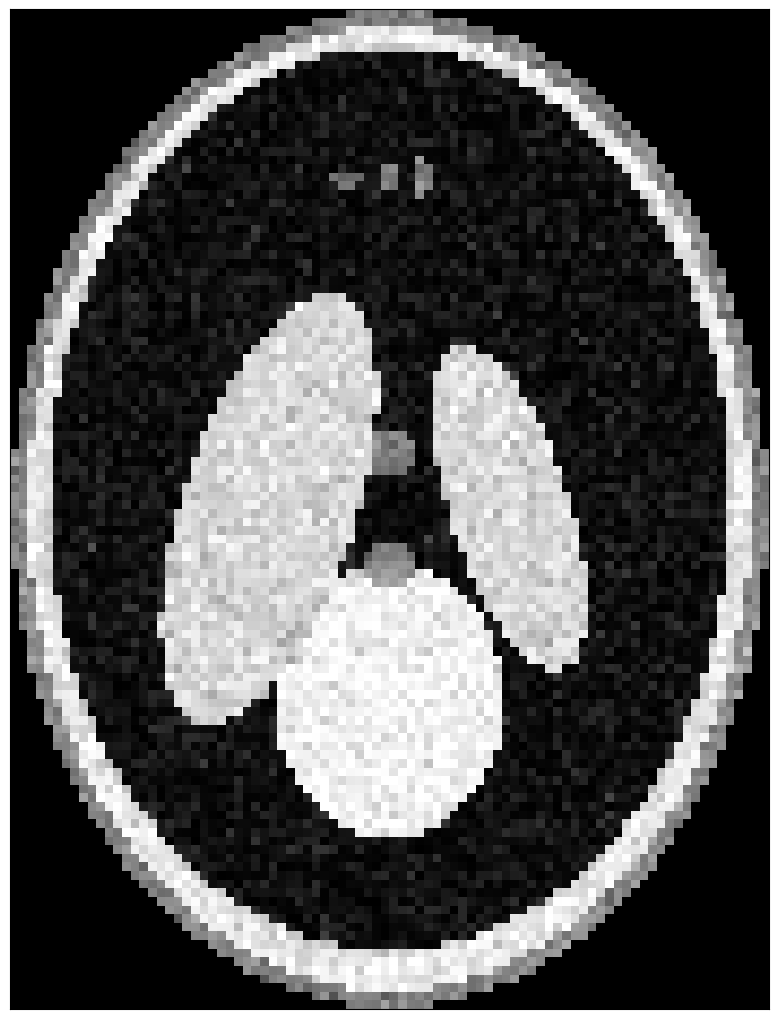

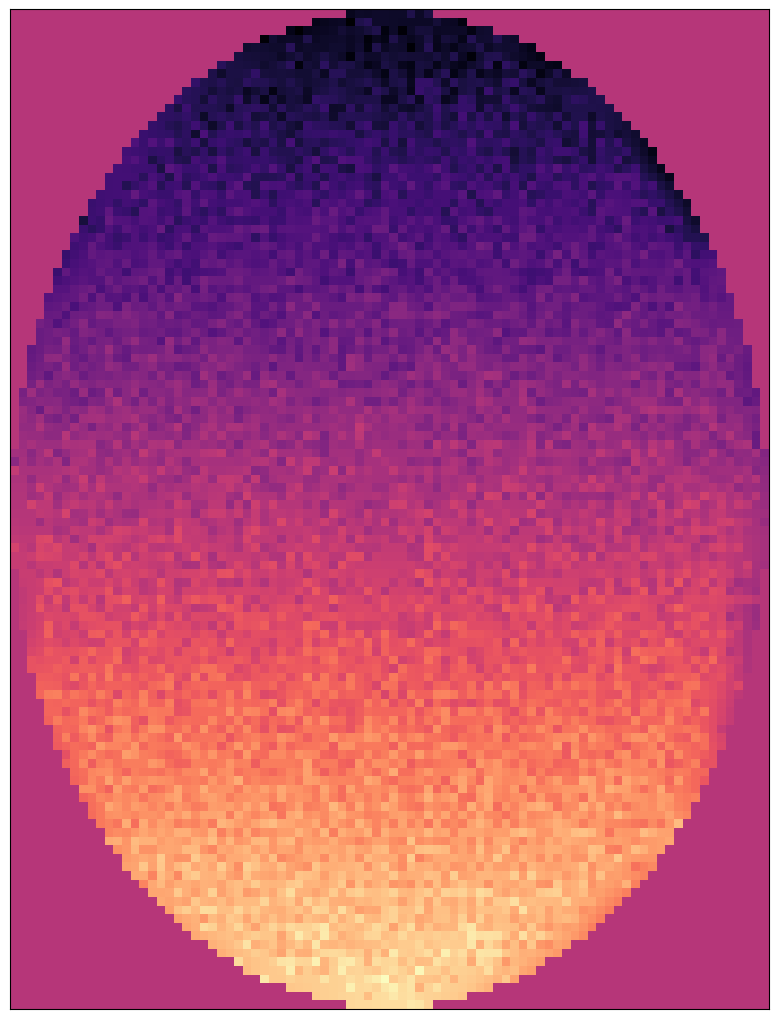

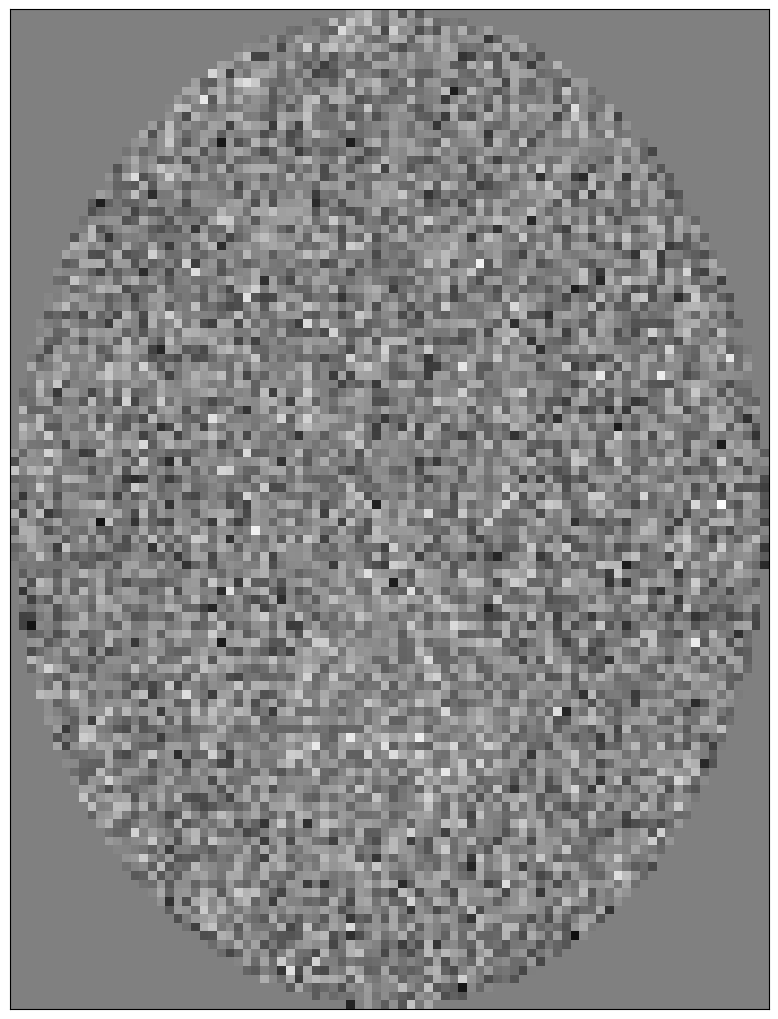

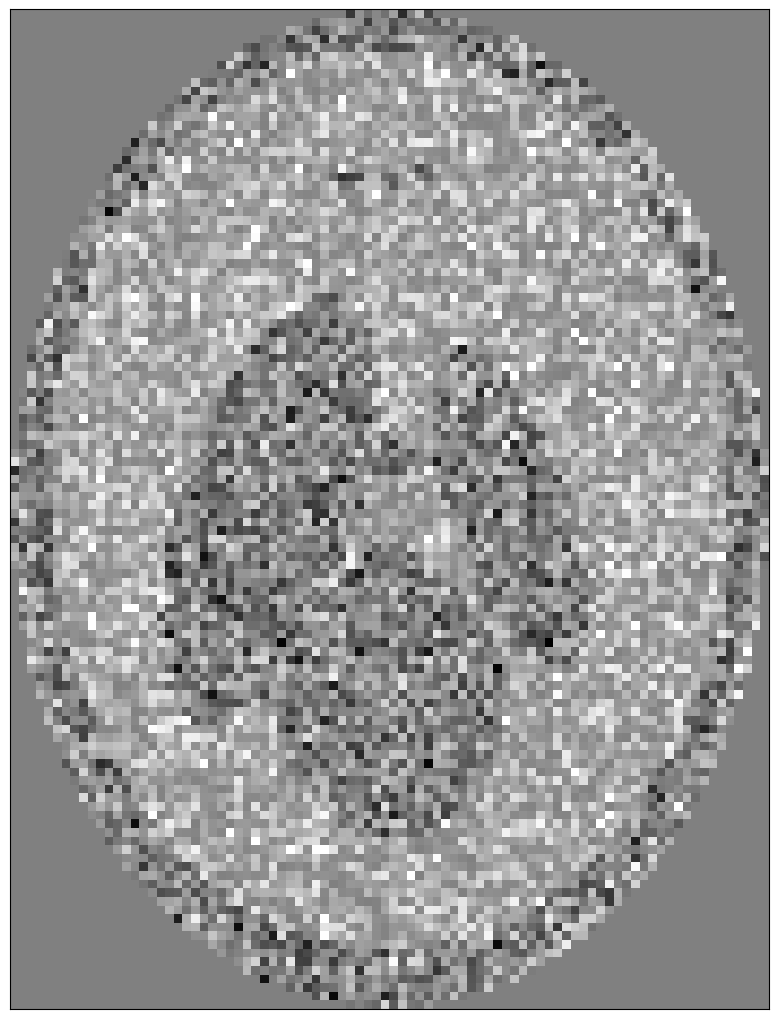

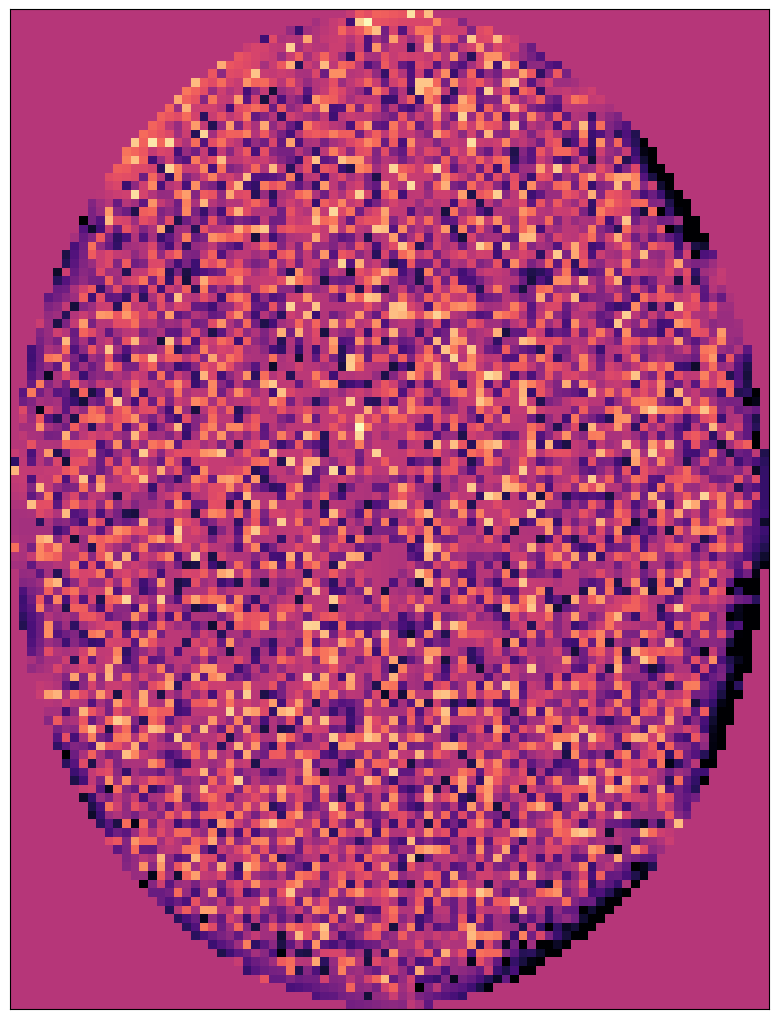

Dual-echo method: multi-res
1/6: Phasors... done! (0.02s)
2/6: Unwrapping... done! (0.03s)
3/6: Low-res... done! (0.07s)
4/6: Mid-res... 

/home/jstelter/2echo-WaterFat-hmrGC/hmrGC_dualEcho/dual_echo.py:209: RuntimeWarning: invalid value encountered in divide
  phasors_masked = phasors_masked / xp.abs(phasors_masked)


done! (0.28s)
5/6: High-res... done! (0.32s)
6/6: Images... done! (0.01s)


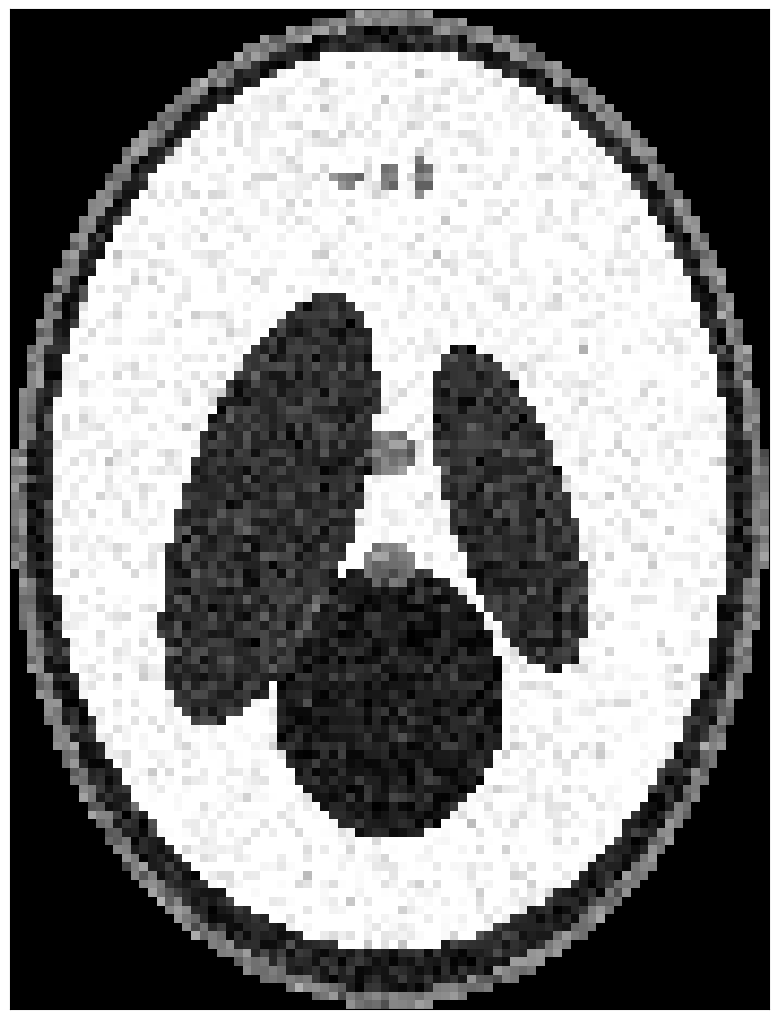

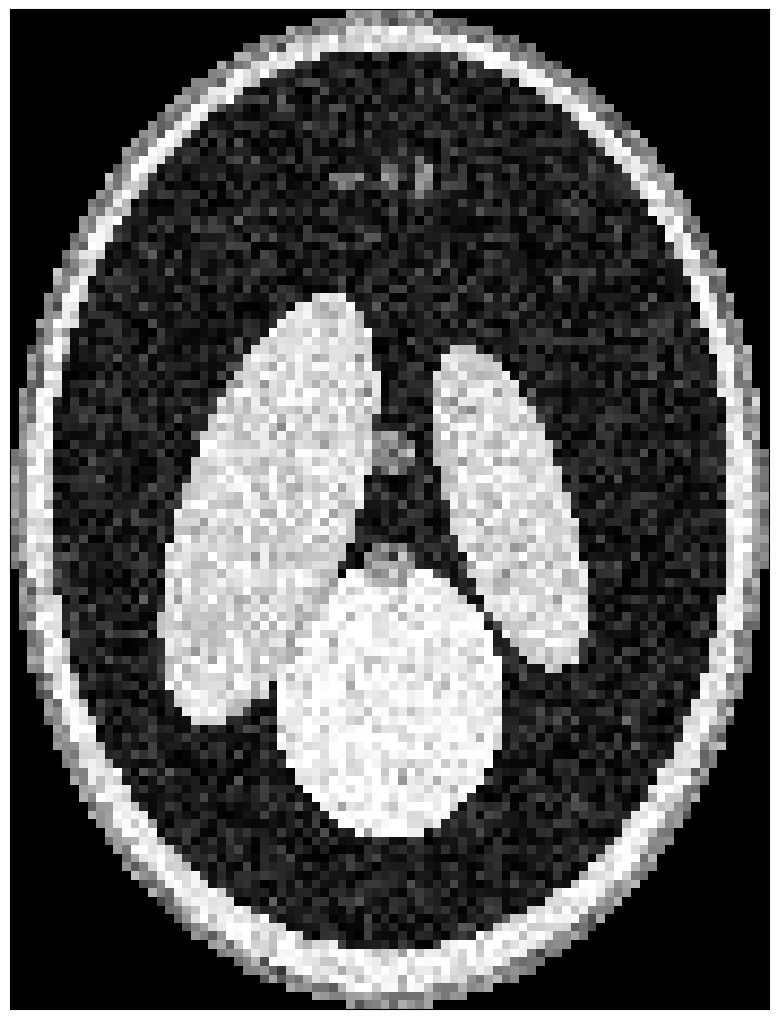

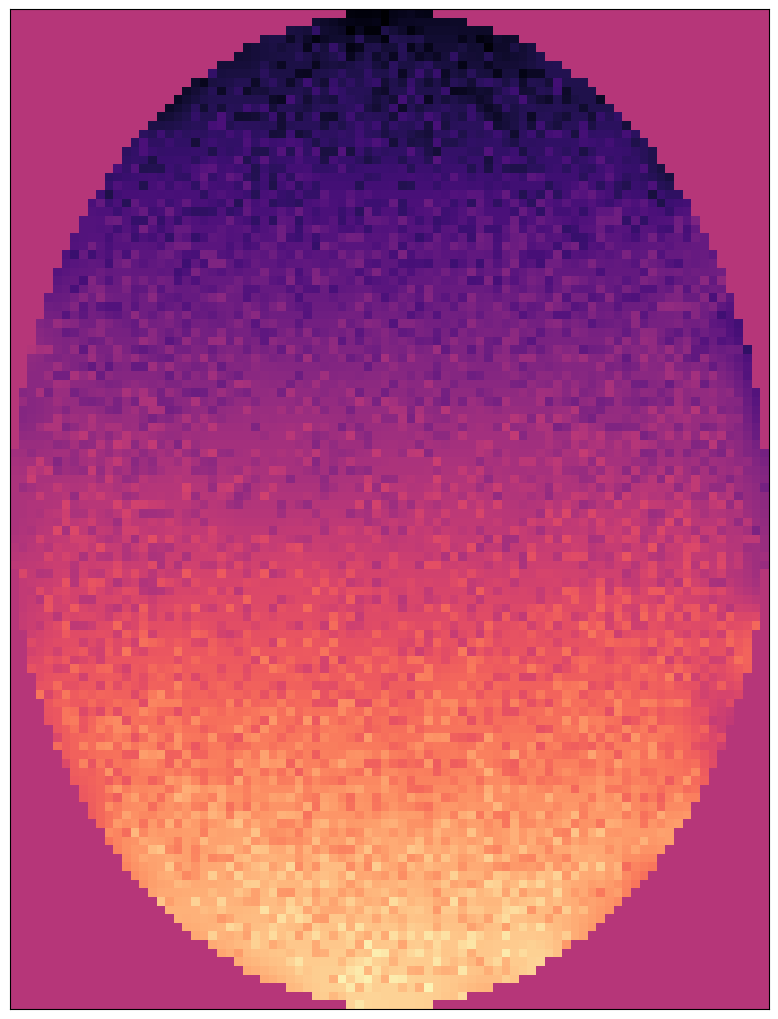

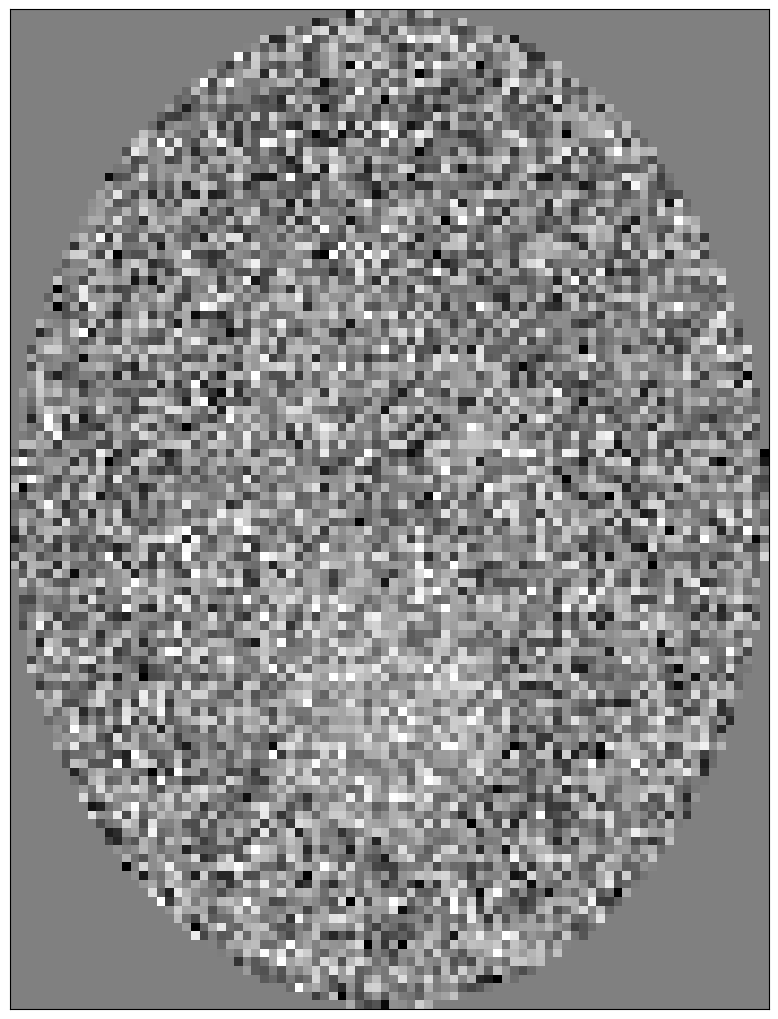

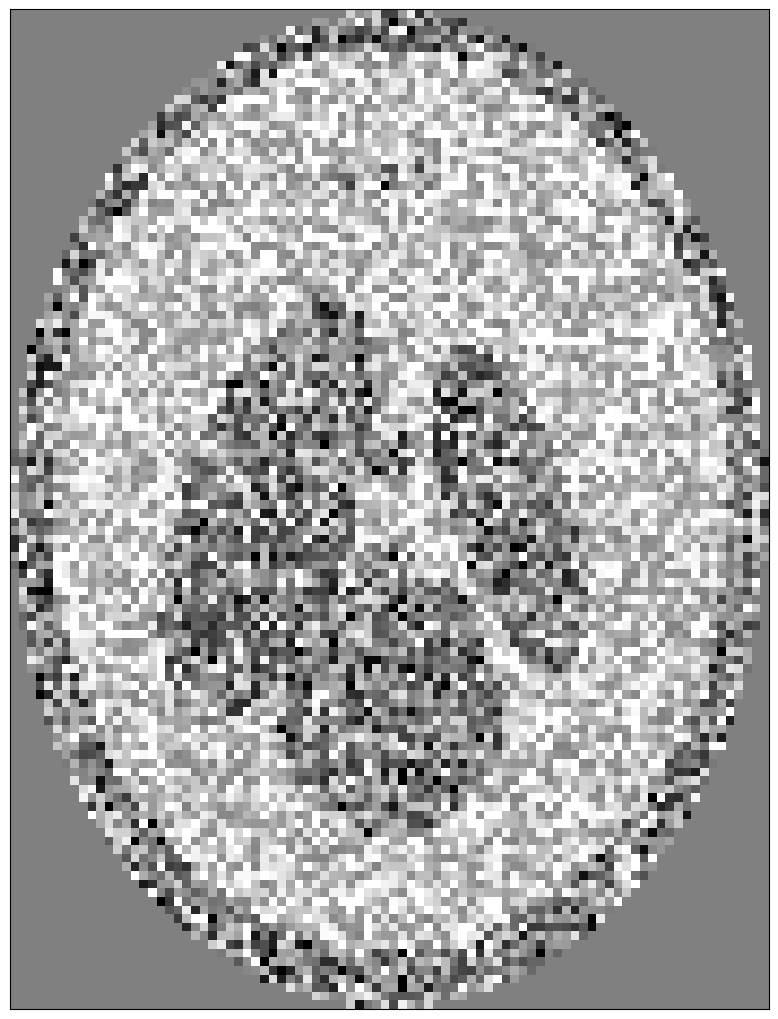

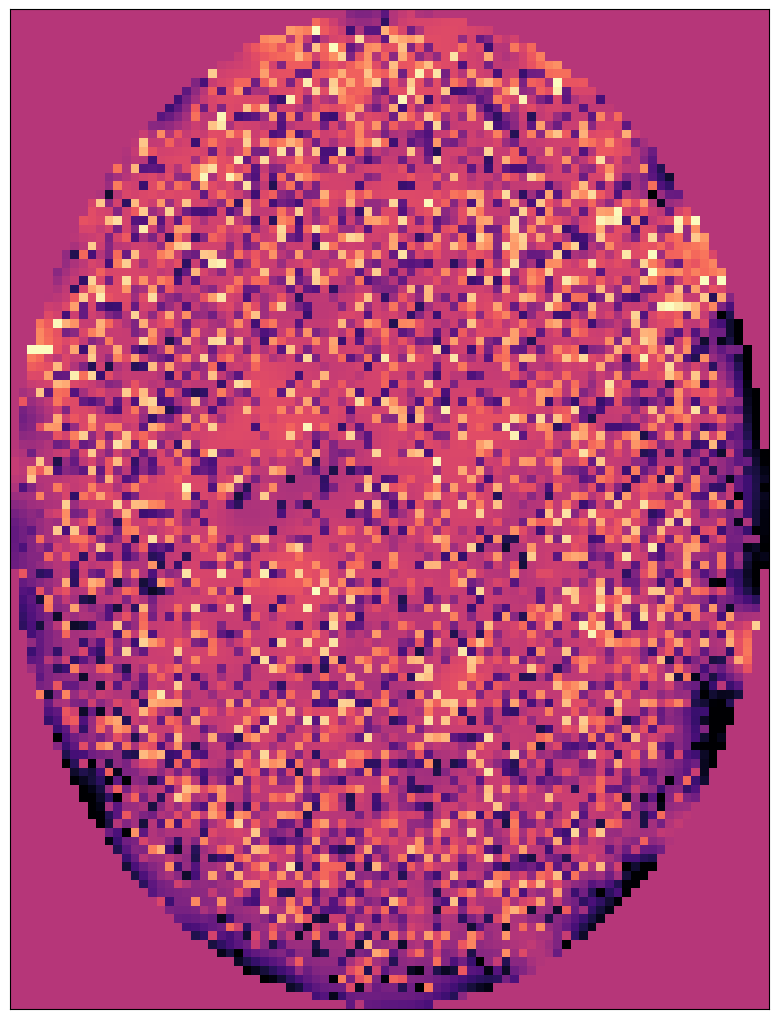

In [20]:
SNRs = [100, 25, 10]
window_mag = np.array([0, np.percentile(np.abs(signal_no_noise), 99)])
for SNR in SNRs:
    signal_power = np.mean(np.abs(signal_no_noise)**2)
    noise_power = signal_power / SNR
    noise_std = np.sqrt(noise_power / 2)
    noise = noise_std * (np.random.normal(size=signal_no_noise.shape) + 1j * np.random.normal(size=signal_no_noise.shape))
    signal = copy.deepcopy(signal_no_noise) + noise

    # Create a DualEcho object
    params = {}
    params['TE_s'] = echoTimes_s   # float array with dim (nte)
    params['centerFreq_Hz'] = centerFreq_MHz*1e6   # float (in Hz, not MHz)
    params['fieldStrength_T'] = fieldstrength_T   # float
    params['voxelSize_mm'] = [1.0, 1.0, 1.0]   # recon voxel size with dim (3)
    params['FatModel'] = fatmodel   # fat model dictionary

    # Initialize DualEcho object
    g = DualEcho(signal, (mask == 0), params)

    # Perform graph-cut method
    g.perform()

    position_3d = [7, 0, 0]
    window_fieldmap = np.array([-200, 200])
    plot_images(np.abs(g.images["water"]), cmap_img_type["water"], ['axial'], params['voxelSize_mm'], position_3d, window_mag, filename=f"water_SNR{SNR}", fig_name="simulation")
    plot_images(np.abs(g.images["fat"]), cmap_img_type["fat"], ['axial'], params['voxelSize_mm'], position_3d, window_mag, filename=f"fat_SNR{SNR}", fig_name="simulation")
    plot_images(g.fieldmap, cmap_img_type["fieldmap"], ['axial'], params['voxelSize_mm'], position_3d, window_fieldmap, filename=f"fieldmap_SNR{SNR}", fig_name="simulation")
    plot_images(np.abs(g.images["water"])-water, cmap_img_type["water"], ['axial'], params['voxelSize_mm'], position_3d, 0.2*np.array([-window_mag[1], window_mag[1]]), filename=f"water_SNR{SNR}_diff", fig_name="simulation")
    plot_images(np.abs(g.images["fat"])-fat, cmap_img_type["fat"], ['axial'], params['voxelSize_mm'], position_3d, 0.2*np.array([-window_mag[1], window_mag[1]]), filename=f"fat_SNR{SNR}_diff", fig_name="simulation")
    plot_images(g.fieldmap-fieldmap, cmap_img_type["fieldmap"], ['axial'], params['voxelSize_mm'], position_3d, 0.2*window_fieldmap, filename=f"fieldmap_SNR{SNR}_diff", fig_name="simulation")

Dual-echo method: single-res
1/3: Phasors... done! (0.02s)
2/3: Phasormap... 

/home/jstelter/2echo-WaterFat-hmrGC/hmrGC_dualEcho/dual_echo.py:209: RuntimeWarning: invalid value encountered in divide
  phasors_masked = phasors_masked / xp.abs(phasors_masked)


done! (0.6s)
3/3: Images... done! (0.01s)


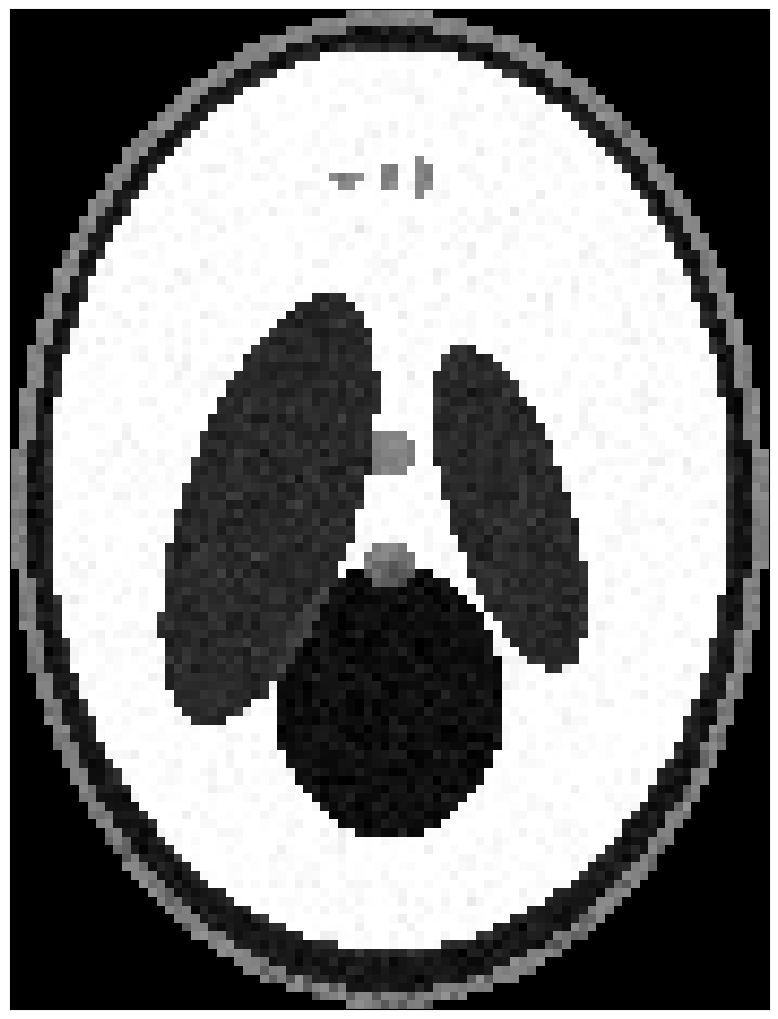

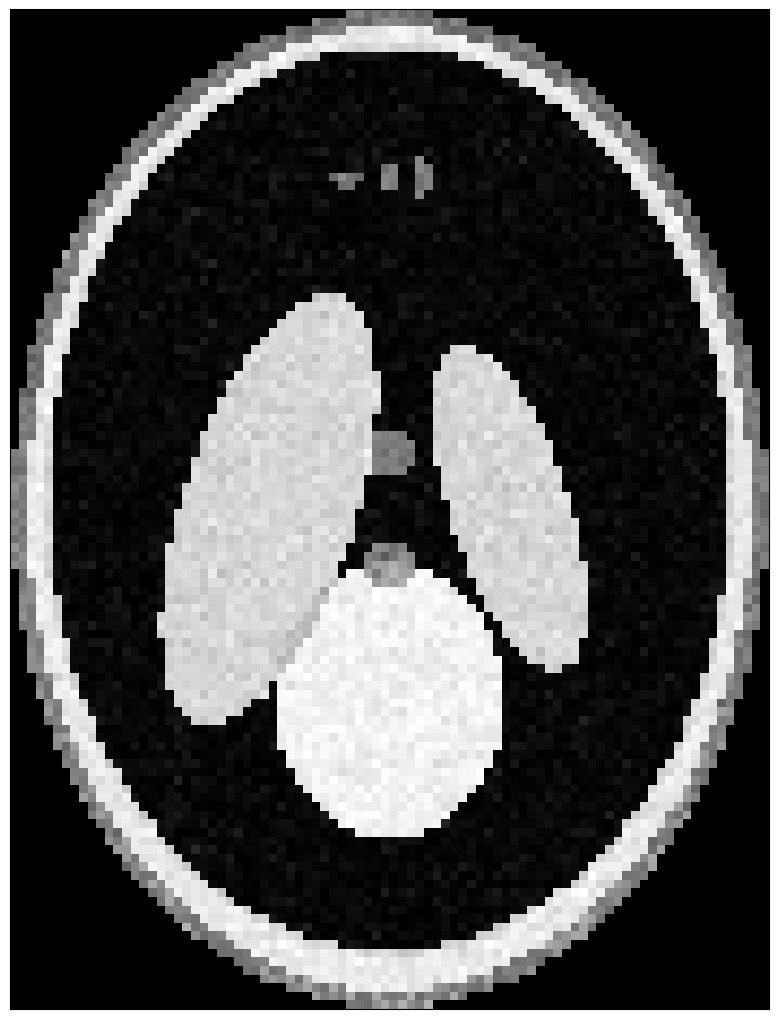

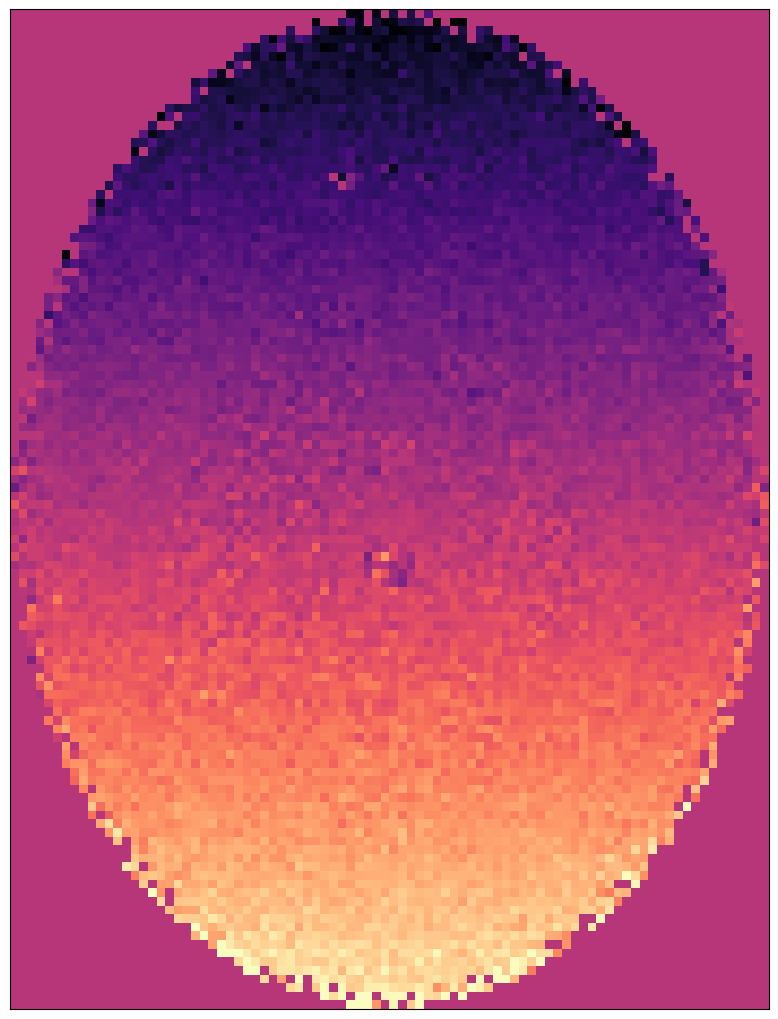

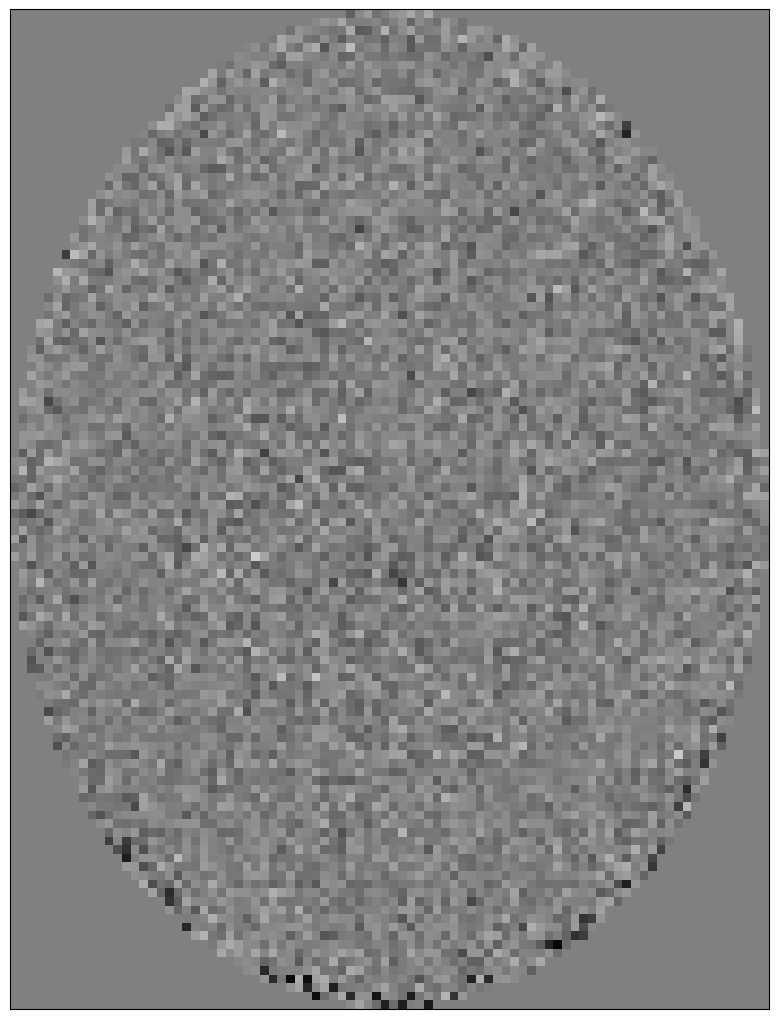

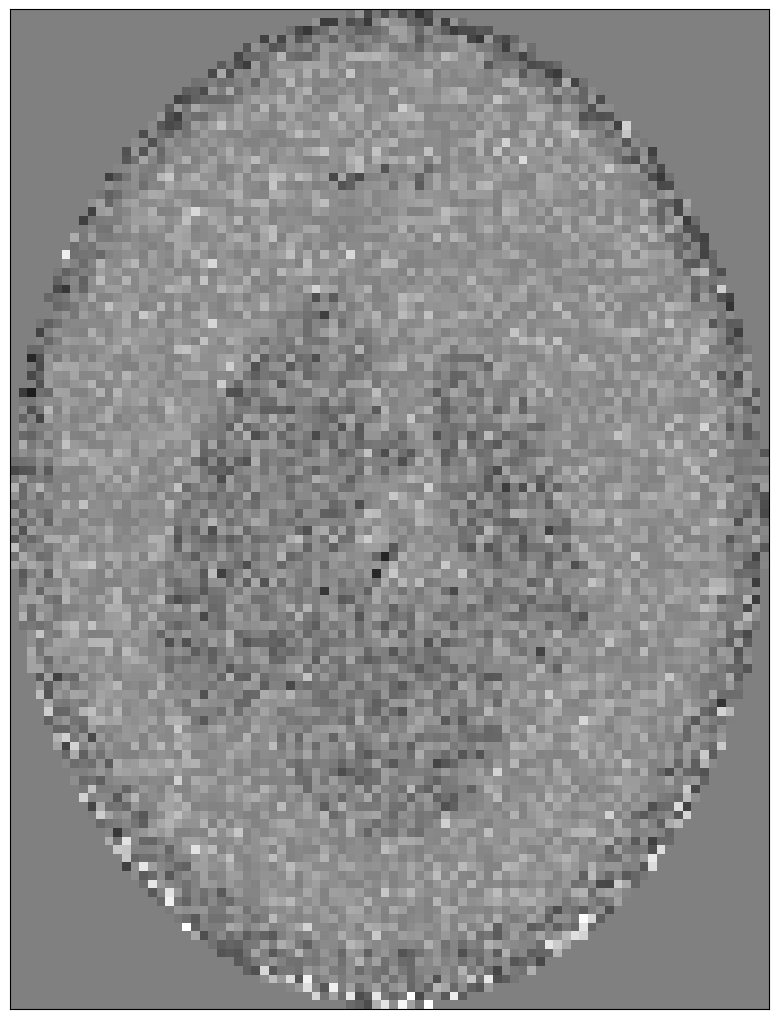

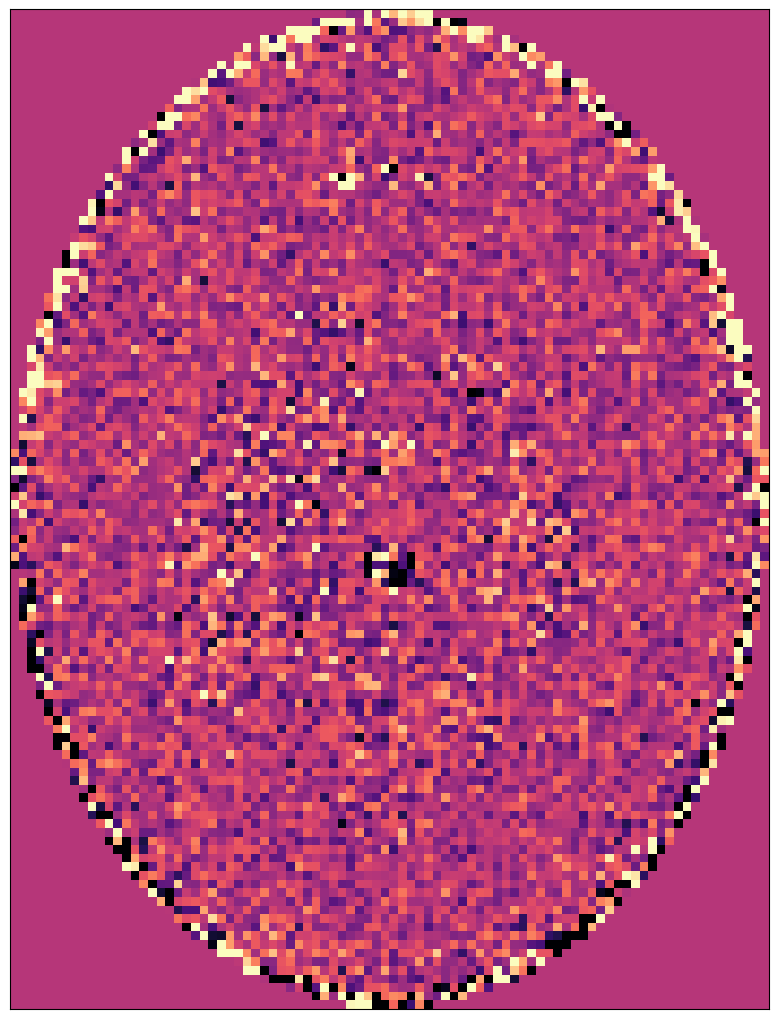

Dual-echo method: single-res
1/3: Phasors... done! (0.02s)
2/3: Phasormap... 

/home/jstelter/2echo-WaterFat-hmrGC/hmrGC_dualEcho/dual_echo.py:209: RuntimeWarning: invalid value encountered in divide
  phasors_masked = phasors_masked / xp.abs(phasors_masked)


done! (0.48s)
3/3: Images... done! (0.01s)


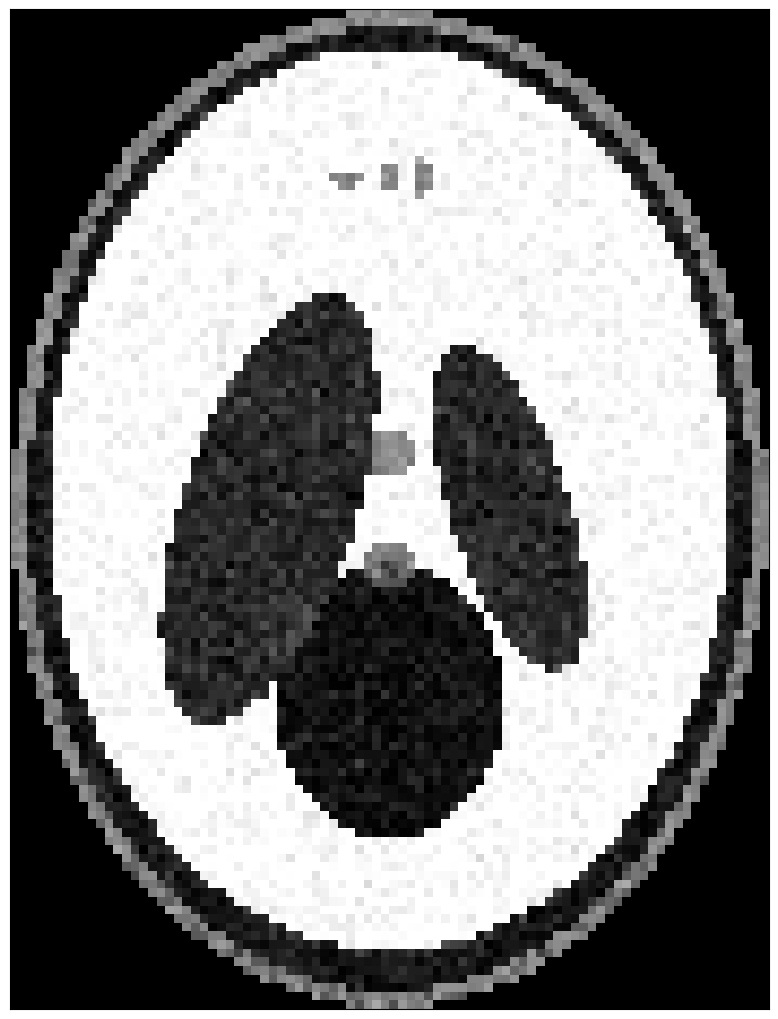

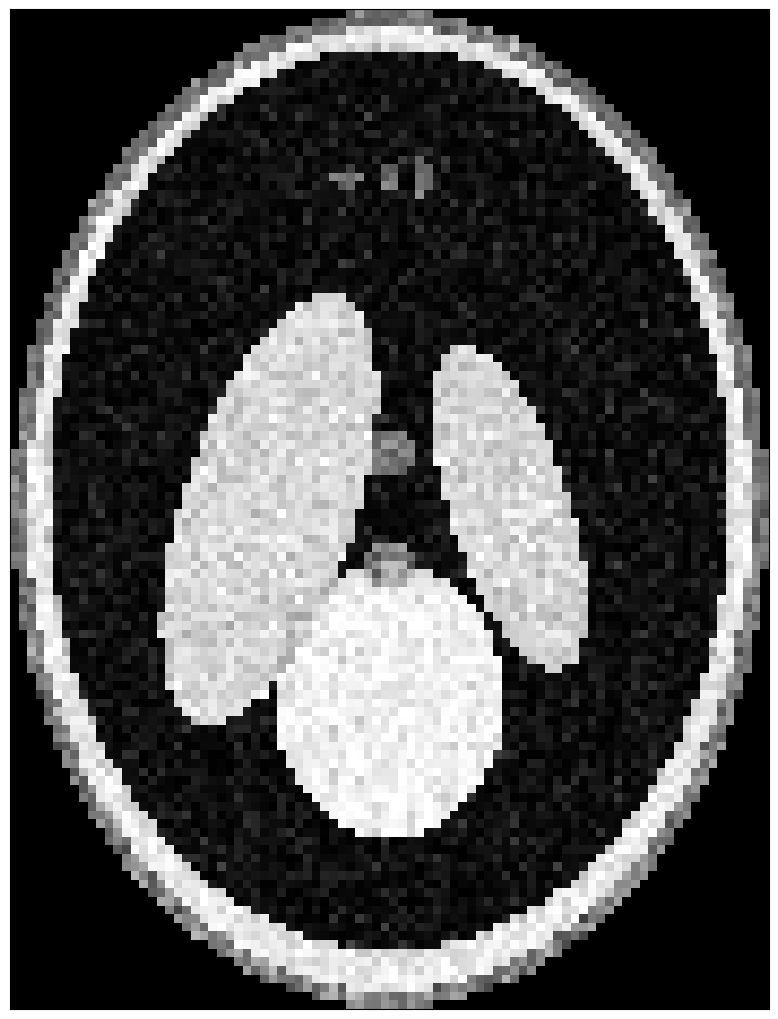

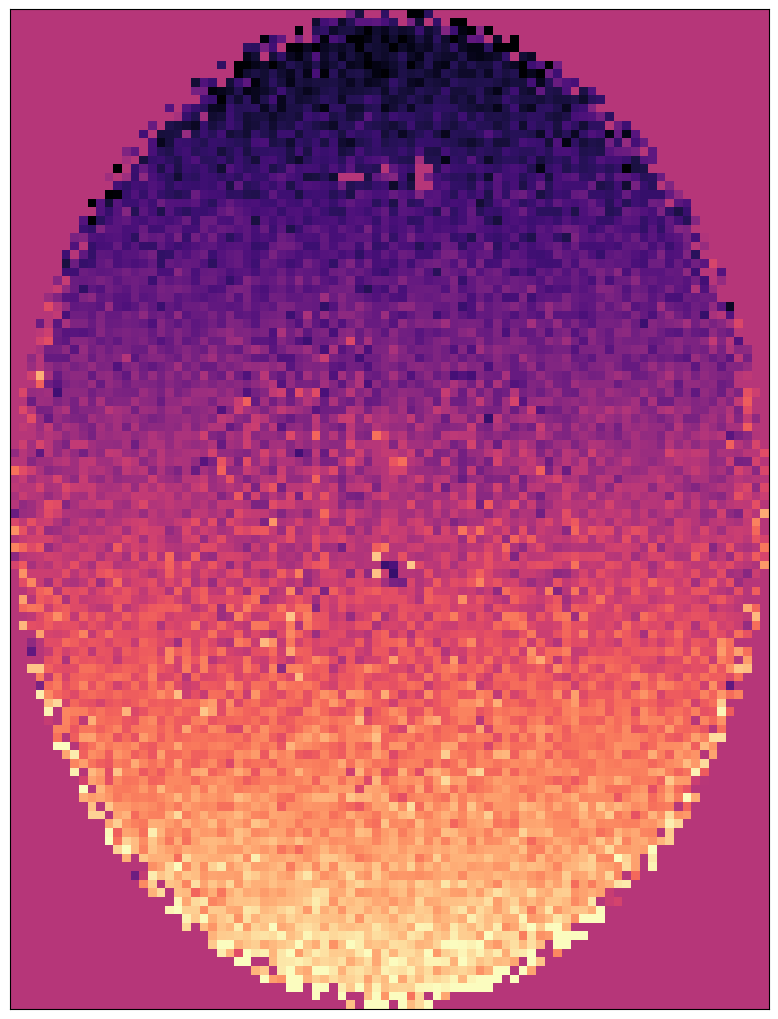

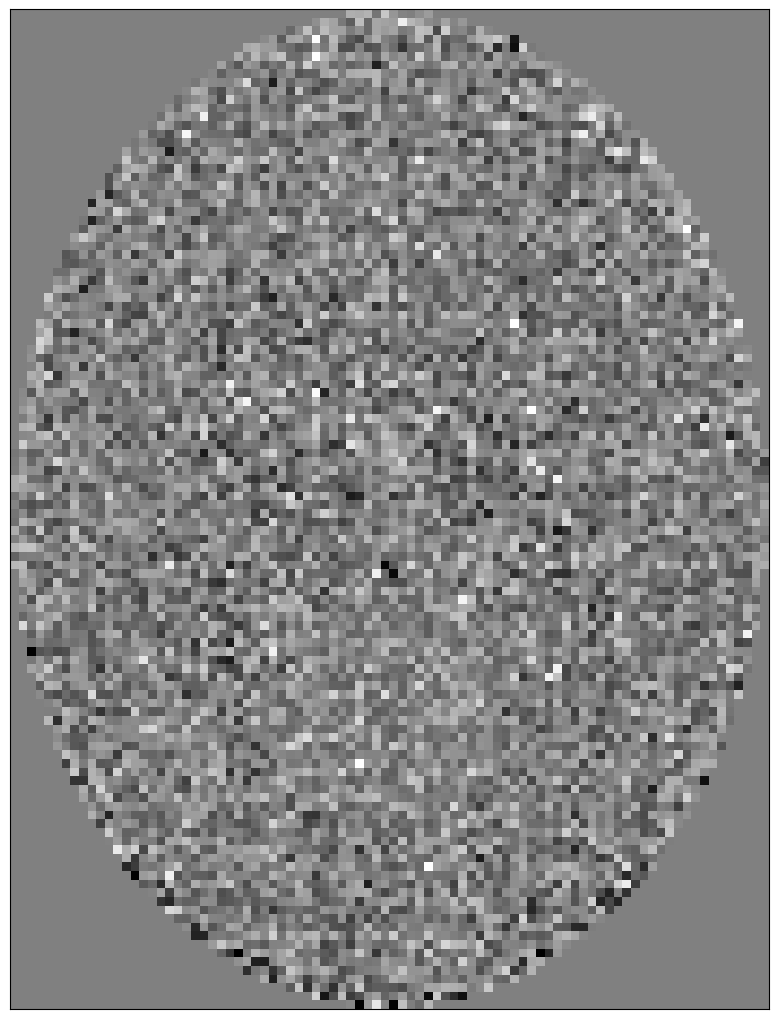

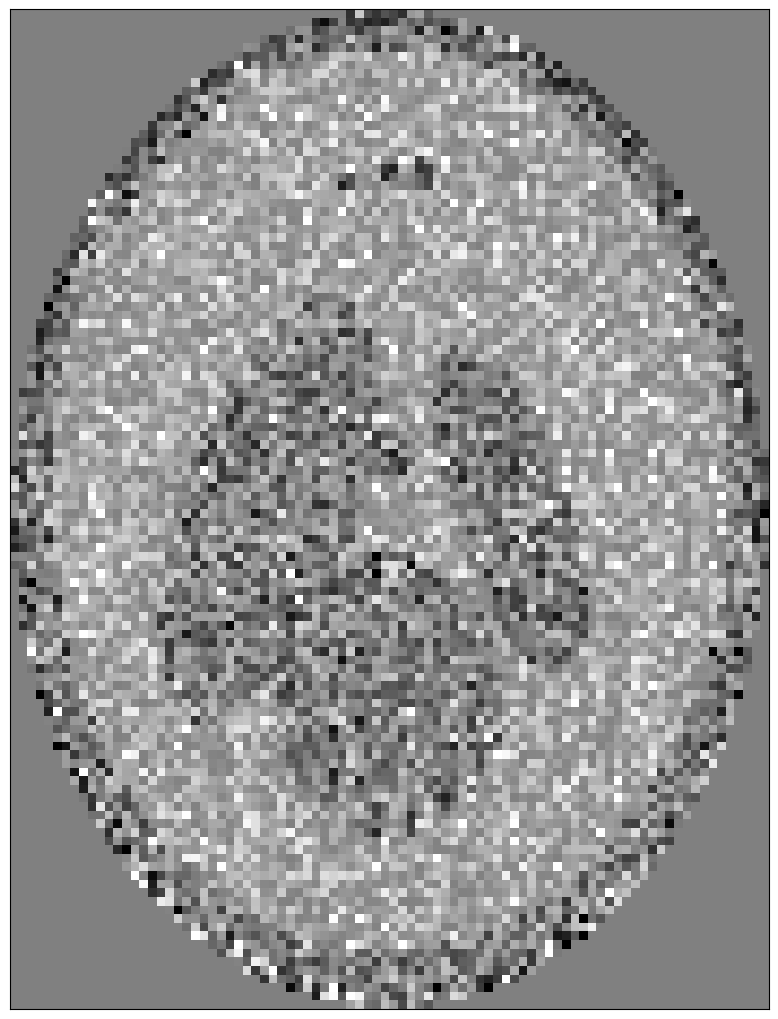

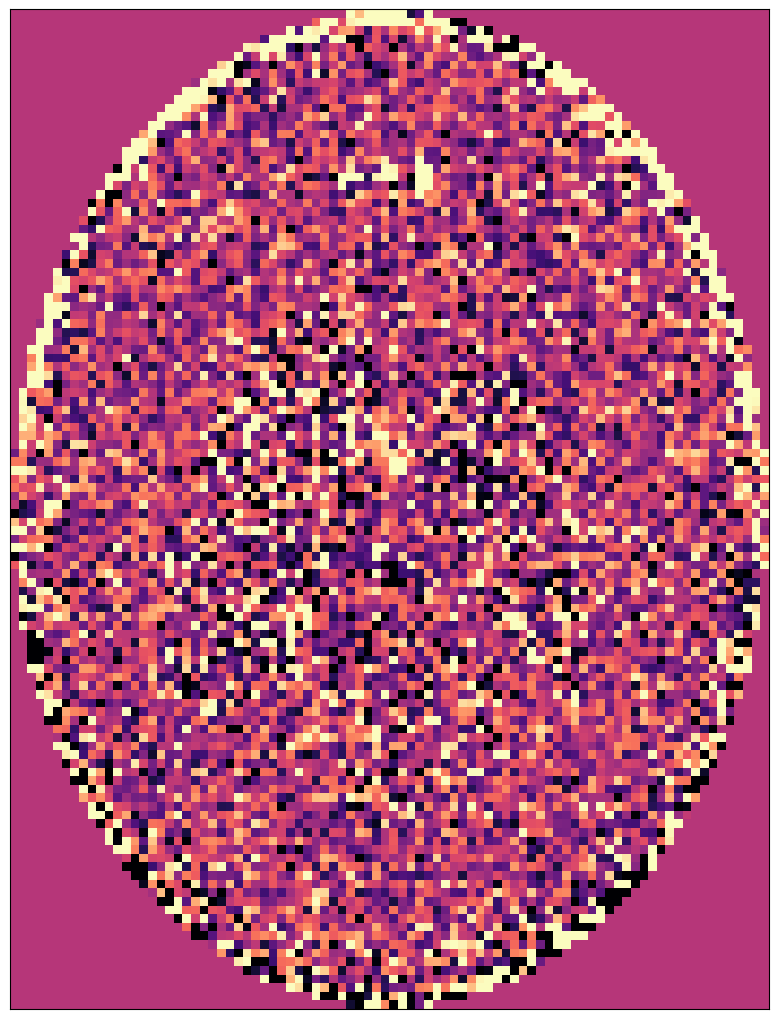

Dual-echo method: single-res
1/3: Phasors... done! (0.02s)
2/3: Phasormap... 

/home/jstelter/2echo-WaterFat-hmrGC/hmrGC_dualEcho/dual_echo.py:209: RuntimeWarning: invalid value encountered in divide
  phasors_masked = phasors_masked / xp.abs(phasors_masked)


done! (0.44s)
3/3: Images... done! (0.01s)


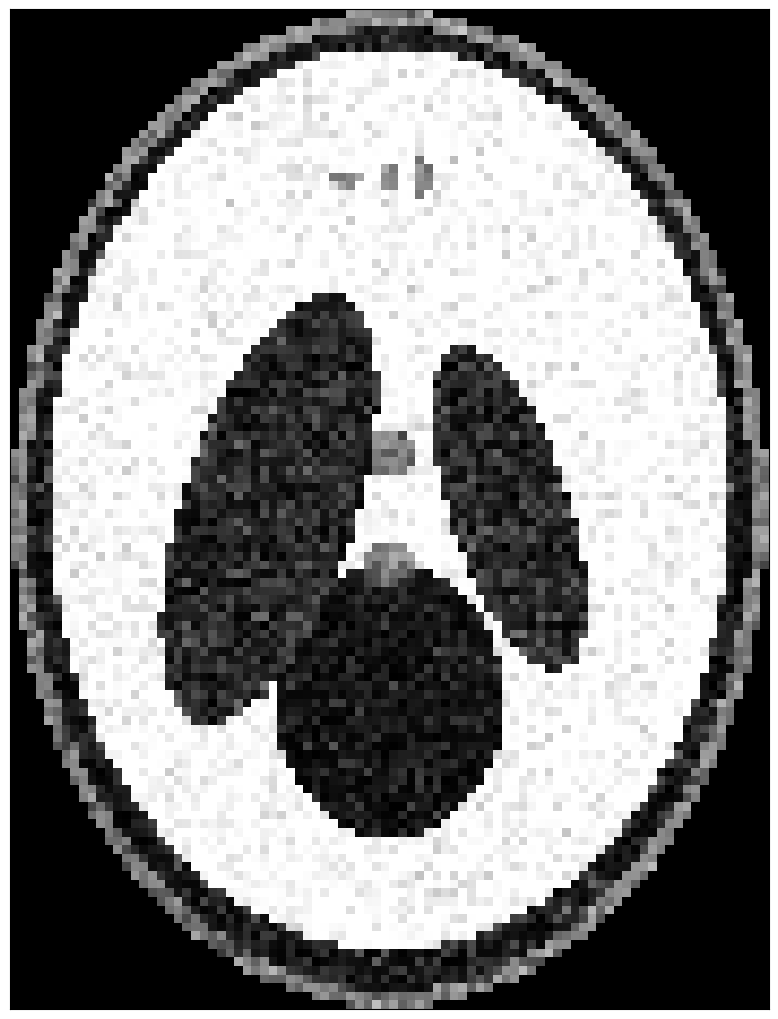

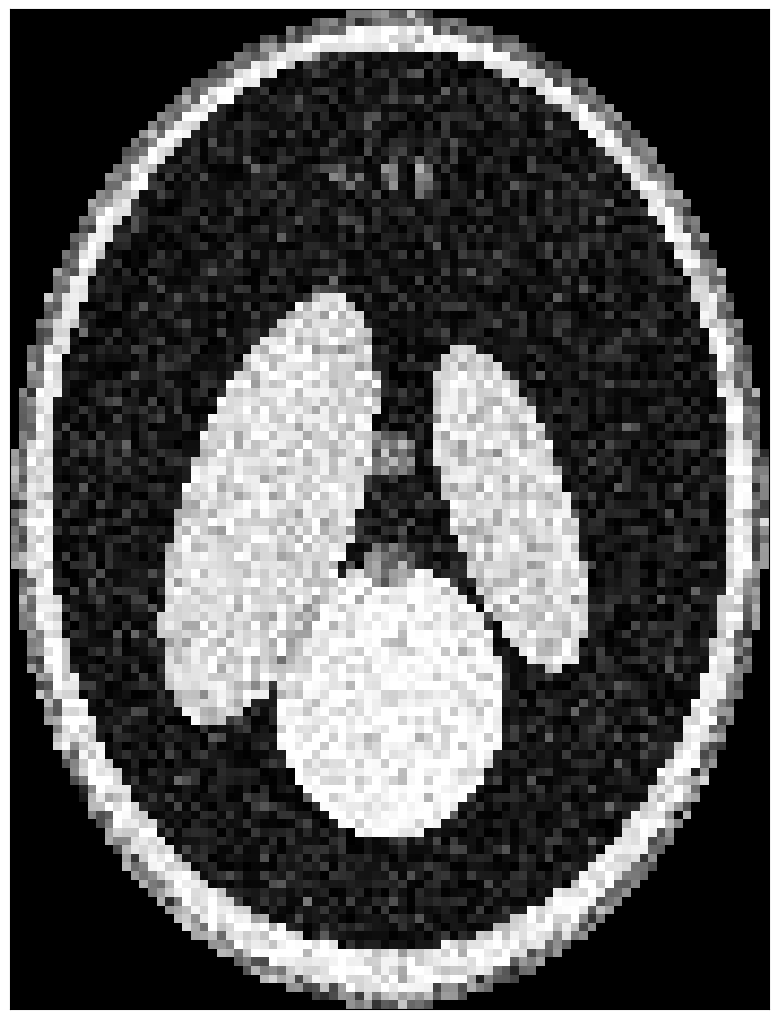

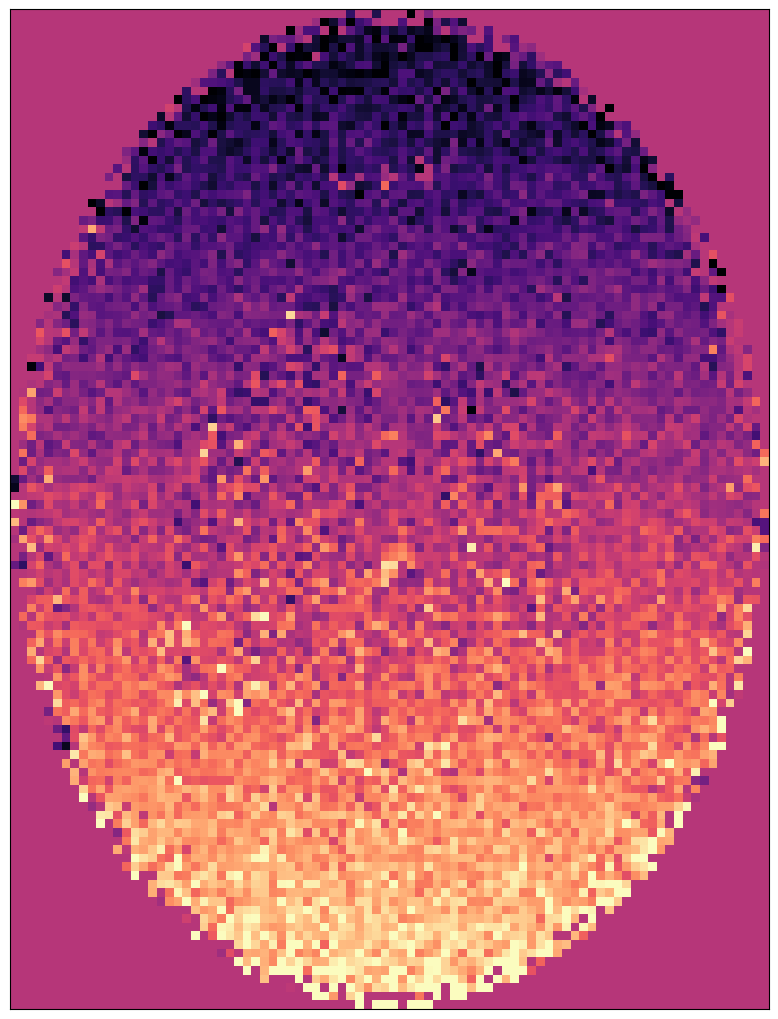

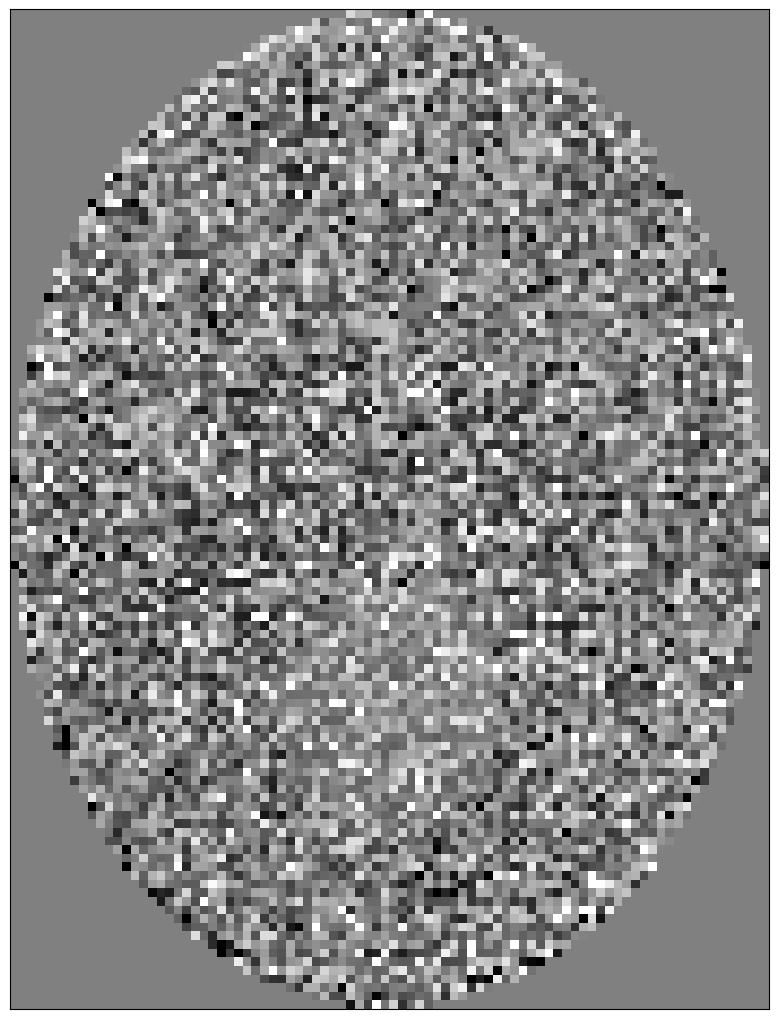

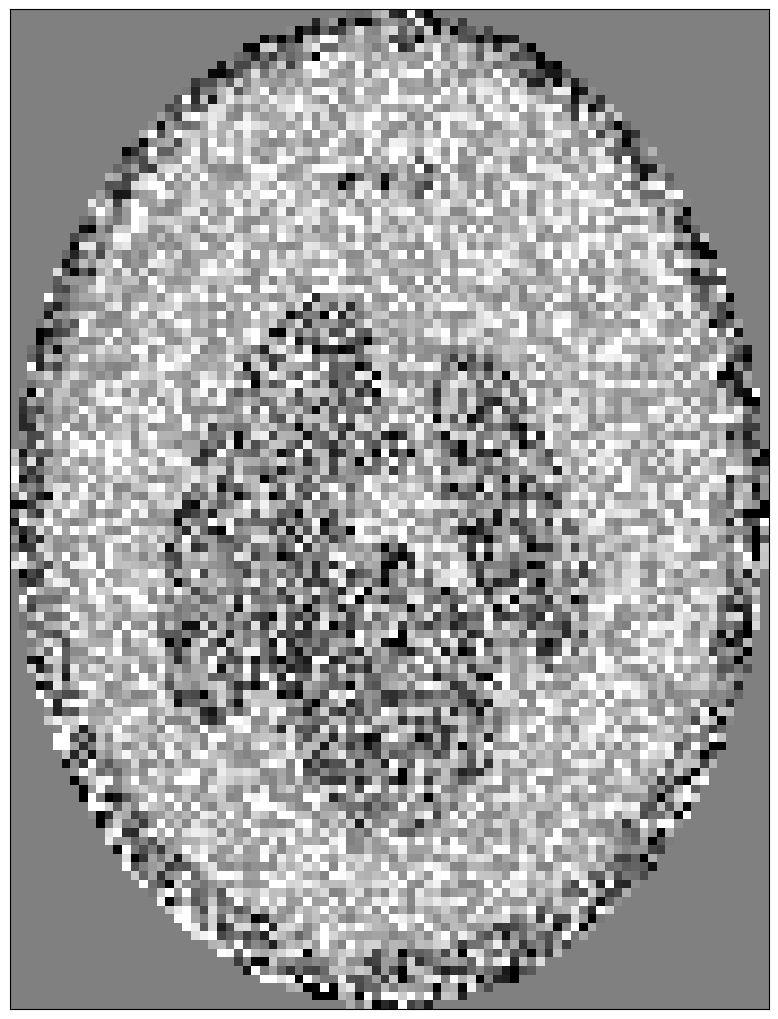

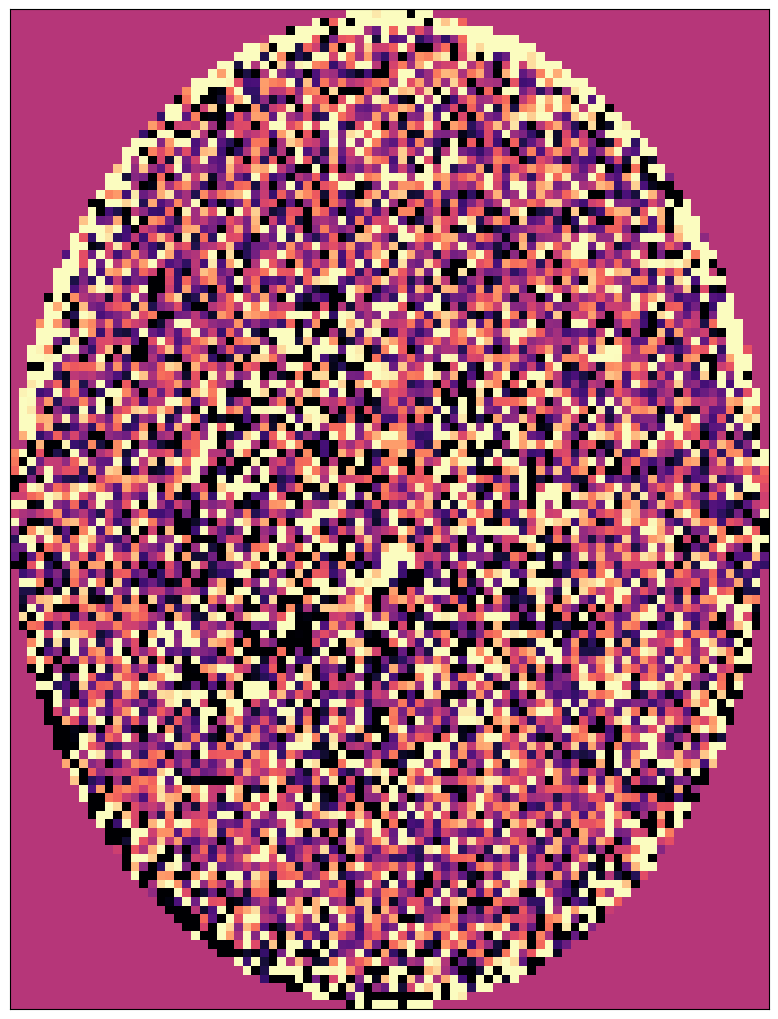

In [21]:
SNRs = [100, 25, 10]
window_mag = np.array([0, np.percentile(np.abs(signal_no_noise), 99)])
for SNR in SNRs:
    signal_power = np.mean(np.abs(signal_no_noise)**2)
    noise_power = signal_power / SNR
    noise_std = np.sqrt(noise_power / 2)
    noise = noise_std * (np.random.normal(size=signal_no_noise.shape) + 1j * np.random.normal(size=signal_no_noise.shape))
    signal = copy.deepcopy(signal_no_noise) + noise

    # Create a DualEcho object
    params = {}
    params['TE_s'] = echoTimes_s   # float array with dim (nte)
    params['centerFreq_Hz'] = centerFreq_MHz*1e6   # float (in Hz, not MHz)
    params['fieldStrength_T'] = fieldstrength_T   # float
    params['voxelSize_mm'] = [1.0, 1.0, 1.0]   # recon voxel size with dim (3)
    params['FatModel'] = fatmodel   # fat model dictionary

    # Initialize DualEcho object
    g = DualEcho(signal, (mask == 0), params)

    # Perform graph-cut method
    g.perform("single-res")

    position_3d = [7, 0, 0]
    window_fieldmap = np.array([-200, 200])
    plot_images(np.abs(g.images["water"]), cmap_img_type["water"], ['axial'], params['voxelSize_mm'], position_3d, window_mag, filename=f"water_SNR{SNR}", fig_name="simulation_singleres")
    plot_images(np.abs(g.images["fat"]), cmap_img_type["fat"], ['axial'], params['voxelSize_mm'], position_3d, window_mag, filename=f"fat_SNR{SNR}", fig_name="simulation_singleres")
    plot_images(g.fieldmap, cmap_img_type["fieldmap"], ['axial'], params['voxelSize_mm'], position_3d, window_fieldmap, filename=f"fieldmap_SNR{SNR}", fig_name="simulation_singleres")
    plot_images(np.abs(g.images["water"])-water, cmap_img_type["water"], ['axial'], params['voxelSize_mm'], position_3d, 0.2*np.array([-window_mag[1], window_mag[1]]), filename=f"water_SNR{SNR}_diff", fig_name="simulation_singleres")
    plot_images(np.abs(g.images["fat"])-fat, cmap_img_type["fat"], ['axial'], params['voxelSize_mm'], position_3d, 0.2*np.array([-window_mag[1], window_mag[1]]), filename=f"fat_SNR{SNR}_diff", fig_name="simulation_singleres")
    plot_images(g.fieldmap-fieldmap, cmap_img_type["fieldmap"], ['axial'], params['voxelSize_mm'], position_3d, 0.2*window_fieldmap, filename=f"fieldmap_SNR{SNR}_diff", fig_name="simulation_singleres")